# Load MNIST data

In [1]:
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

lentrainset = list(range(len(trainset)))
# Split train set and test set
lentrainsubset, lenvalsubset = train_test_split(lentrainset, test_size=0.2, random_state=36)

trainsubset = torch.utils.data.Subset(trainset, lentrainsubset)
valsubset = torch.utils.data.Subset(trainset, lenvalsubset)

testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

trainloader = torch.utils.data.DataLoader(trainsubset, batch_size=32, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valsubset, batch_size=32, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)



In [2]:
print(f"Train size: {len(trainsubset)}, Valid Size: {len(valsubset)}, Test size: {len(testset)}")

Train size: 48000, Valid Size: 12000, Test size: 10000


## Vitualize training dataset

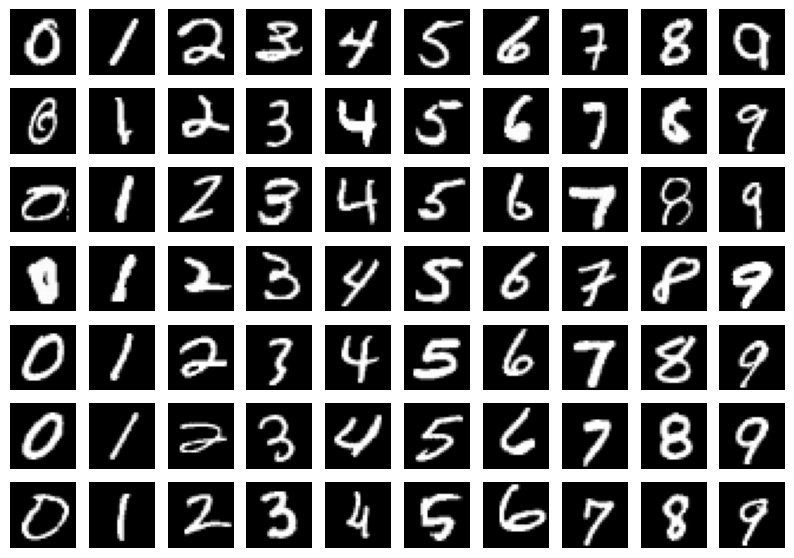

In [3]:
fig, axes = plt.subplots(7, 10, figsize=(10, 7))
j = 0

for i, ax in enumerate(axes.flat):
    image, label = trainsubset[j]
    while label != i % 10:
        j += 1
        image, label = trainsubset[j]

    ax.imshow(image[0], cmap='gray')
    ax.axis('off')

# Define Lenet5 model

In [4]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # Convolution 1 & Pooling 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=9, kernel_size=3, padding=1)
        self.AvgPool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Convolution 2 & Pooling 2
        self.conv2 = nn.Conv2d(in_channels=9, out_channels=36, kernel_size=5)
        self.AvgPool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Convolution 3
        self.conv3 = nn.Conv2d(in_channels=36, out_channels=72, kernel_size=2)

        # Flatten
        self.Flatten = nn.Flatten()

        # Full Connected 1, 2
        self.fc1 = nn.Linear(72*4*4, 96)
        self.fc2 = nn.Linear(96, 10)

        self.tanh = nn.Tanh()


    def forward(self, x):
        x = self.tanh(self.conv1(x))
        x = self.AvgPool1(x)
        x = self.tanh(self.conv2(x))
        x = self.AvgPool2(x)
        x = self.tanh(self.conv3(x))

        x = self.Flatten(x)
        x = self.tanh(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)

        return x

# Define `Train_model` function

In [5]:
def Train_model():
    model.train()
    total_loss = 0.0


    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        predictions = model(inputs)
        loss = loss_fn(predictions, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()


    loss = total_loss / len(trainloader)
    return loss


# Define `Valid_model` function

In [6]:
def Valid_model():
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)

            predictions = model(inputs)
            loss = loss_fn(predictions, labels)

            total_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(predictions, 1)
            correct_predictions += (predicted == labels).sum().item() # (TP + TN)
            total_samples += inputs.size(0) # (TP + TN + FP + FN)


    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples # accuracy = (TP + TN) / (TP + TN + FP + FN)

    return avg_loss, accuracy


## Define `Early_stopping` function

In [7]:
class Early_stopping():
    def __init__(self, patience=6, delta=0):
        self.patience = patience
        self.delta = delta

        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state = None


    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.best_model_state = model.state_dict()
        elif val_loss < self.best_score - self.delta:
            self.best_score = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)


# Create required

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5().to(device)

loss_fn = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer
early_stopping = Early_stopping(patience=100, delta=0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)


In [9]:
num_epochs = 10000
trainloss_list = []
valloss_list = []
valaccuracy_list = []

for epoch in range(num_epochs):
    train_loss = Train_model()
    val_loss, val_accuracy = Valid_model()

    scheduler.step(val_loss)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    trainloss_list.append(train_loss)
    valloss_list.append(val_loss)
    valaccuracy_list.append(val_accuracy)

    print(f"Epoch: {epoch + 1} / {num_epochs}, Average training loss: {train_loss:.9f},  Validation loss: {val_loss:.9f}, Validation accuracy: {val_accuracy:.9f}", end=', ')

    # In learning rate
    for param_group in optimizer.param_groups:
        print(f"Learning Rate = {param_group['lr']}")


early_stopping.load_best_model(model)
print("Done training")


Epoch: 1 / 10000, Average training loss: 1.567268408,  Validation loss: 1.515099192, Validation accuracy: 0.954083333, Learning Rate = 0.001
Epoch: 2 / 10000, Average training loss: 1.506059108,  Validation loss: 1.498389933, Validation accuracy: 0.967250000, Learning Rate = 0.001
Epoch: 3 / 10000, Average training loss: 1.493395833,  Validation loss: 1.494963894, Validation accuracy: 0.970250000, Learning Rate = 0.001
Epoch: 4 / 10000, Average training loss: 1.487618413,  Validation loss: 1.487909207, Validation accuracy: 0.975750000, Learning Rate = 0.001
Epoch: 5 / 10000, Average training loss: 1.484310735,  Validation loss: 1.489500031, Validation accuracy: 0.974083333, Learning Rate = 0.001
Epoch: 6 / 10000, Average training loss: 1.482266599,  Validation loss: 1.487891135, Validation accuracy: 0.975500000, Learning Rate = 0.001
Epoch: 7 / 10000, Average training loss: 1.479500178,  Validation loss: 1.485255898, Validation accuracy: 0.977083333, Learning Rate = 0.001
Epoch: 8 / 10

# Define `Evaludate_model` function

In [10]:
# Hàm tính accuracy, và đồng thời lưu predict và output khi model dự đoán trên tập test
def Evaludate_model():
    model.eval()
    correct = 0
    total = 0

    output_labels = np.array([])
    predict_labels = np.array([])


    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            predictions = model(inputs)
            _, predicted = torch.max(predictions, 1)

            total += labels.size(0)

            correct += (predicted == labels).sum().item()

            output_labels = np.append(output_labels, labels.cpu().numpy())
            predict_labels = np.append(predict_labels, predicted.cpu().numpy())


    return correct / total, output_labels, predict_labels


In [12]:
from sklearn.metrics import confusion_matrix, classification_report

accuracy, output_label, predict_label = Evaludate_model()

# in ra accuracy
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

# in ra confusion matrix
cm = confusion_matrix(output_label, predict_label)
print('Confusion matrix:\n', cm)

# in ra classification report
report = classification_report(output_label, predict_label, target_names=["number " + str(i) for i in range(10)])
print('Classification report:\n', report)


Accuracy on test set: 98.75%
Confusion matrix:
 [[ 971    1    0    0    1    1    2    1    2    1]
 [   0 1127    2    2    1    0    1    0    2    0]
 [   1    1 1026    1    0    0    0    3    0    0]
 [   0    0    2 1004    0    2    0    1    1    0]
 [   0    0    1    0  973    0    1    0    0    7]
 [   2    0    0    8    0  878    3    0    0    1]
 [   3    2    2    0    1    4  945    0    1    0]
 [   0    4   11    3    0    0    0 1009    0    1]
 [   4    0    3    2    2    3    0    0  959    1]
 [   3    1    1    3    6    3    1    4    4  983]]
Classification report:
               precision    recall  f1-score   support

    number 0       0.99      0.99      0.99       980
    number 1       0.99      0.99      0.99      1135
    number 2       0.98      0.99      0.99      1032
    number 3       0.98      0.99      0.99      1010
    number 4       0.99      0.99      0.99       982
    number 5       0.99      0.98      0.98       892
    number 6      

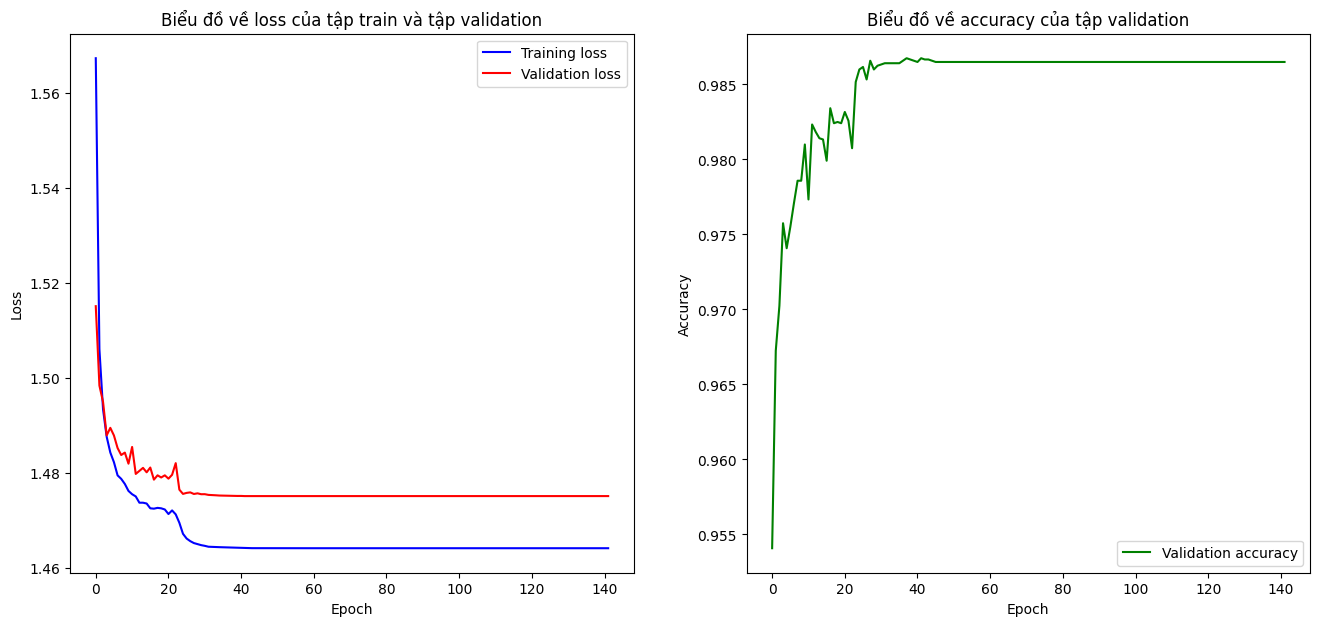

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].plot(trainloss_list, label='Training loss', color='blue')
axes[0].plot(valloss_list, label='Validation loss', color='red')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Biểu đồ về loss của tập train và tập validation')
axes[0].legend()

axes[1].plot(valaccuracy_list, label='Validation accuracy', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Biểu đồ về accuracy của tập validation')
axes[1].legend()

plt.show()
